# This notebook will reproduce a plot similar to Fig. 6 left of 2503.10805

### - Start importing libraries

In [ ]:
# Global
import sys
import tqdm
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")

# Local
import examples_utils as eu
import fastPTA.utils as ut
from fastPTA.Fisher_code import compute_fisher
from fastPTA.signals import get_signal_model

### - Constants to be used in the analysis

In [44]:
# PRESENT CONFIGURATION
# Total observation time in years
T_obs_yrs = 16.03

# Number of pulsars in the analysis
n_pulsars = 120

# Specify the type of noise to be used in the analysis
which_experiment = eu.EPTAlike

# FUTURE CONFIGURATION
# Total observation time in years
T_obs_yrs_future = 10.33

# Number of pulsars in the analysis
n_pulsars_future = 200

# Specify the type of noise to be used in the analysis
which_experiment_future = eu.mockSKA10


# Number of frequencies used in the analysis
n_frequencies = 100

# Set the label to specify the signal model
signal_label = "power_law_SIGW"

# Current SMBBH SGWB best-fit paramteres
SMBBH_log_amplitude = -7.1995
SMBBH_tilt = 2

# The analysis assumes a SIGW template, specify here the input parameters
SIGW_log_amplitude = -1.7
SIGW_log_width = np.log10(0.5)
SIGW_log_pivot = -8.45

# Specify the true signal parameters
SMBBH_parameters = np.array([SMBBH_log_amplitude, SMBBH_tilt])

CGW_SIGW_parameters = np.array(
    [SIGW_log_amplitude, SIGW_log_width, SIGW_log_pivot]
)

s_params = np.array(np.concatenate([SMBBH_parameters, CGW_SIGW_parameters]))
s_params_future = np.array(
    np.concatenate([SMBBH_parameters, CGW_SIGW_parameters])
)

# Specify the labels for the signal parameters
parameter_labels = []

# Flag to regenerate all the data
regenerate_data = False

# Flag to regenerate the pulsare catalogs, if true will also regenerate the data
regenerate_catalogs = False

# Specify the indices of the parameters to vary
parameter_index1 = 3  # set 4 to vary f*
parameter_index2 = 2

# Set the ranges over which perform the scan, larger numbers for finer grid
n_points = 12

# we want n_points to be odd
n_points += 1 if n_points % 2 == 0 else 0

# Set the range of the parameters to scan over
parameter_range1 = np.array(np.linspace(-1, 0.5, n_points))
parameter_range2 = np.array(np.linspace(-2.5, 0, n_points))

# Paths of Fisher data
path_to_Fisher_data = f"generated_data/Fisher_{n_pulsars}_{parameter_index1}_{parameter_index2}_alphamean.npz"
path_to_Fisher_data_future = f"generated_data/Fisher_{n_pulsars_future}_{parameter_index1}_{parameter_index2}_alphamean.npz"

### - Set the inputs for the Fisher analysis

In [45]:
# Get the signal model
signal_model = get_signal_model(signal_label)

# Dictionaries with the kwargs to generete the pulsar catalogs
generate_catalog_kwargs = {
    "n_pulsars": n_pulsars,
    "save_catalog": True,
    **which_experiment,
}

generate_catalog_kwargs_future = {
    "n_pulsars": n_pulsars_future,
    "save_catalog": True,
    **which_experiment_future,
}

# Dictionaries with the kwargs to generate noise and orf tensors
get_tensors_kwargs = {
    "path_to_pulsar_catalog": "pulsar_configurations/EPTA120.txt",
    "add_curn": False,
    "regenerate_catalog": regenerate_catalogs,
}

get_tensors_kwargs_future = {
    "path_to_pulsar_catalog": "pulsar_configurations/SKA200.txt",
    "add_curn": False,
    "regenerate_catalog": regenerate_catalogs,
}

fisher_kwargs = {
    "T_obs_yrs": T_obs_yrs,
    "n_frequencies": n_frequencies,
    "signal_model": signal_model,
    "signal_parameters": s_params,
}

fisher_kwargs_future = {
    "T_obs_yrs": T_obs_yrs_future,
    "n_frequencies": n_frequencies,
    "signal_model": signal_model,
    "signal_parameters": s_params_future,
}

In [46]:
# A function that computes the Fisher matrix for all the points in the grid
# and saves the results to a file + returns the results
def generate_fisher_grid(
    parameters,
    parameter_range1,
    parameter_range2,
    fisher_kwargs,
    get_tensors_kwargs,
    generate_catalog_kwargs,
    outpath,
):

    # Initialize the results array
    results_fisher = np.zeros(
        shape=(
            len(parameter_range1),
            len(parameter_range2),
            len(parameters),
            len(parameters),
        )
    )

    # Loop over the grid
    for i in tqdm.tqdm(range(len(parameter_range1))):
        for j, p2 in enumerate(parameter_range2):
            # Set the parameters to the current values for the fisher computation
            parameters[parameter_index1] = parameter_range1[i]
            parameters[parameter_index2] = p2
            fisher_kwargs["signal_parameters"] = parameters

            # Compute the Fisher matrix
            _, _, _, _, _, _, results_fisher[i, j] = compute_fisher(
                **fisher_kwargs,
                get_tensors_kwargs=get_tensors_kwargs,
                generate_catalog_kwargs=generate_catalog_kwargs
            )

    # Save the results to a file
    np.savez(
        outpath,
        parameter_range1=parameter_range1,
        parameter_range2=parameter_range2,
        results_fisher=results_fisher,
    )

    return results_fisher

### - Compute a Fisher matrix for each point in the grid <br /> NB with the current settings this will take around 15 minutes

In [48]:
try:
    if regenerate_data or get_tensors_kwargs["regenerate_catalog"]:
        raise FileNotFoundError

    print("Using stored data")
    file = np.load(path_to_Fisher_data)
    file_future = np.load(path_to_Fisher_data_future)
    parameter_range1 = file["parameter_range1"]
    parameter_range2 = file["parameter_range2"]
    results_fisher = file["results_fisher"]
    results_fisher_future = file_future["results_fisher"]
    
    middle_point = ( len(results_fisher) -1 ) /2  # for the plot

except FileNotFoundError:
    print("Regenerating the data")

    middle_point = int(n_points / 4)

    # Present configuration
    results_fisher = generate_fisher_grid(
        s_params,
        parameter_range1,
        parameter_range2,
        fisher_kwargs,
        get_tensors_kwargs,
        generate_catalog_kwargs,
        path_to_Fisher_data,
    )

    # Future configuration
    results_fisher_future = generate_fisher_grid(
        s_params_future,
        parameter_range1,
        parameter_range2,
        fisher_kwargs_future,
        get_tensors_kwargs_future,
        generate_catalog_kwargs_future,
        path_to_Fisher_data_future,
    )

Using stored data


### - Evaluate the relative uncertainties on $A_{\zeta}$

In [59]:
results_amplitude = np.zeros(
    shape=(len(parameter_range1), len(parameter_range2))
)
results_amplitude_future = np.zeros(
    shape=(len(parameter_range1), len(parameter_range2))
)

# Define a very weak prior on the parameters to avoid numerical issues in sqrt
priors = 1e-4 * np.eye(len(s_params))


for i in range(len(parameter_range1)):
    for j in range(len(parameter_range2)):
        covariance = ut.compute_inverse(results_fisher[i, j] + priors)
        results_amplitude[i, j] = np.sqrt(np.diag(covariance)[2])

        covariance_future = ut.compute_inverse(results_fisher_future[i, j] + priors)
        results_amplitude_future[i, j] = np.sqrt(np.diag(covariance_future)[2])

results_amplitude = results_amplitude * np.log(10)
results_amplitude_future = results_amplitude_future * np.log(10)

### - Contour plot

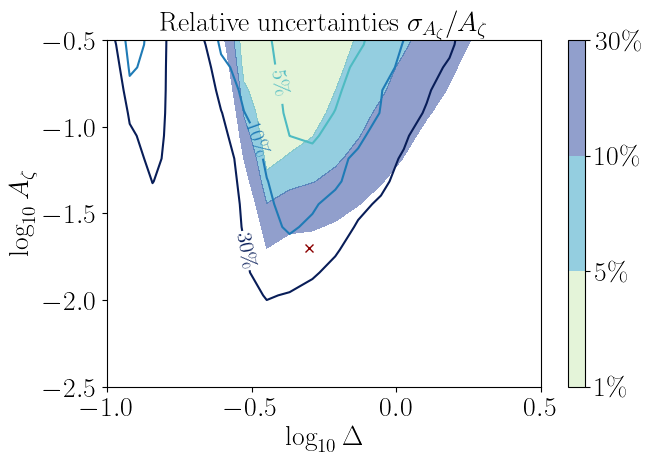

In [60]:
fig = plt.figure(figsize=(7, 4.5))
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"


ax = plt.contour(
    parameter_range1,
    parameter_range2,
    np.log10(results_amplitude.T),
    levels=[np.log10(1e-2), np.log10(5e-2), np.log10(1e-1), np.log10(3e-1)],
    cmap="YlGnBu",
)

labels_locations = [(-1, 0), (-0.4, -0.75), (-0.5, -1.1), (-0.5, -1.7)]
txt_objects = plt.clabel(
    ax,
    inline=True,
    inline_spacing=0,
    fmt="%2.1f",
    use_clabeltext=True,
    fontsize=15,
    manual=labels_locations,
)

new_labels = [r"1$\%$", r"5$\%$", r"10$\%$", r"30$\%$"]
for t, l in zip(txt_objects, new_labels):
    t.set(text=l)

plt.contourf(
    parameter_range1,
    parameter_range2,
    np.log10(results_amplitude_future.T),
    levels=[np.log10(1e-2), np.log10(5e-2), np.log10(1e-1), np.log10(3e-1)],
    cmap="YlGnBu",
    alpha=0.5,
)

plt.plot(np.log10(0.5), -1.7, "x", c="darkred")
cbar = plt.colorbar()
cbar.set_ticklabels([r"1$\%$", r"5$\%$", r"10$\%$", r"30$\%$"], fontsize=20)
plt.xlim(-1, 0.5)
plt.ylim(-2.5, -0.5)
plt.xlabel(r"$\log_{10}\Delta$", fontsize=20)
plt.ylabel(r"$\log_{10}A_{\zeta}$", fontsize=20)
plt.tick_params(axis="both", labelsize=20)
plt.title(r"Relative uncertainties $\sigma_{A_{\zeta}}/A_{\zeta}$", fontsize=20)
plt.show()